In [1]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import ConvLSTM2D
from keras.layers import BatchNormalization
from keras.layers import RepeatVector
from keras.layers import Dropout
from numpy import hstack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import cryptowatch as cw

In [2]:
def augmento_sent(symbol):
    dataset= pd.read_csv('augmento_{}.csv'.format(symbol))
    col=dataset.columns
    #Choosen Bad&Good
    imp_col_index_good=[40,41,93,25,75]
    imp_col_index_bad=[28,16,3,55,16,8,75,56,87]
    #Timestamp
    icolindex_good=[0]
    icolindex_bad=[0]
    #Extend counting of good 
    icolindex_good.extend([i for i in imp_col_index_good])
    icolindex_good.extend([i+93 for i in imp_col_index_good])
    icolindex_good.extend([i+93*2 for i in imp_col_index_good]) 
    #Extend counting of bad
    icolindex_bad.extend([i for i in imp_col_index_bad])
    icolindex_bad.extend([i+93 for i in imp_col_index_bad])
    icolindex_bad.extend([i+93*2 for i in imp_col_index_bad])
    #date 
    dataset_good=dataset.loc[:,col[icolindex_good]]
    dataset_bad=dataset.loc[:,col[icolindex_bad]]
    #time to date
    dataset_good['date']=pd.to_datetime(dataset_good['date']).dt.date
    dataset_bad['date']=pd.to_datetime(dataset_bad['date']).dt.date
    #sum arrange
    dataset_good=dataset_good.groupby('date').sum().sum(axis=1)
    dataset_bad=dataset_bad.groupby('date').sum().sum(axis=1)
    dataset= pd.concat([dataset_good,dataset_bad],axis=1)
    #create new dataset
    dataset=dataset.rename(columns={0:'pos',1:'neg'})
    dataset['sentiment']=(dataset['pos']-dataset['neg'])*(dataset['pos']+dataset['neg'])
    return dataset['sentiment']

def daily_coin(symbol):
    dataset= pd.read_csv('{}_daily.csv'.format(symbol))
    dataset['timestamp']=pd.date_range(start="2016-11-04",end="2022-01-18")
    dataset.index=dataset['timestamp']
    return dataset

In [3]:
def calc_rsi(dataset):
    dataset = pd.DataFrame(dataset,columns=["open","high","low","close"])
    coin_rsi=dataset.copy()
    data=coin_rsi.copy()
    a=coin_rsi.columns[3]
    coin_rsi.drop(coin_rsi.columns.difference([a]), 1, inplace=True)
    coin_rsi=coin_rsi.reset_index(drop=True,inplace=False)
    coin_rsi["diff"]=coin_rsi.diff(1)

    coin_rsi['gain'] = coin_rsi['diff'].clip(lower=0).round(2)
    coin_rsi['loss'] = coin_rsi['diff'].clip(upper=0).abs().round(2)
    coin_rsi

    window_length=14
    # Get initial Averages
    coin_rsi['avg_gain'] = coin_rsi['gain'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]
    coin_rsi['avg_loss'] = coin_rsi['loss'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]
    # View Result

    # View first SMA value

    for i, row in enumerate(coin_rsi['avg_gain'].iloc[window_length+1:]):
        coin_rsi['avg_gain'].iloc[i + window_length + 1] =\
          (coin_rsi['avg_gain'].iloc[i + window_length] *
          (window_length - 1) +
          coin_rsi['gain'].iloc[i + window_length + 1])\
          / window_length
    # Average Losses
    for i, row in enumerate(coin_rsi['avg_loss'].iloc[window_length+1:]):
        coin_rsi['avg_loss'].iloc[i + window_length + 1] =\
          (coin_rsi['avg_loss'].iloc[i + window_length] *
          (window_length - 1) +
          coin_rsi['loss'].iloc[i + window_length + 1])\
          / window_length
    # View initial results

    coin_rsi['rs'] = coin_rsi['avg_gain'] / coin_rsi['avg_loss']
    coin_rsi['rsi'] = 100 - (100 / (1.0 + coin_rsi['rs']))

    # View Result

    return coin_rsi["rsi"]

In [4]:
Sentiment_btc=augmento_sent("btc")
Sentiment_eth=augmento_sent("eth")

In [5]:
btc_price=daily_coin('btc')
eth_price=daily_coin('eth')

In [6]:
btc_rsi=calc_rsi(btc_price)
btc_rsi.index=btc_price['timestamp']
btc_price['rsi']=btc_rsi
eth_rsi=calc_rsi(eth_price)
eth_rsi.index=eth_price['timestamp']
eth_price['rsi']=eth_rsi

In [7]:
eth_price["rsi"][eth_price["rsi"].isnull()]=0
btc_price["rsi"][btc_price["rsi"].isnull()]=0

<ipython-input-7-f02d08f5d4dd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eth_price["rsi"][eth_price["rsi"].isnull()]=0
<ipython-input-7-f02d08f5d4dd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc_price["rsi"][btc_price["rsi"].isnull()]=0


In [8]:
eth_dataset= pd.concat([Sentiment_eth,eth_price],axis=1)
eth_dataset=eth_dataset.dropna()
eth_dataset=eth_dataset.reset_index(drop=True)
eth_dataset=eth_dataset[['rsi','open','high','low','close']]#[['pos','neg','sentiment','open','high','low','close']]

In [9]:
btc_dataset= pd.concat([Sentiment_btc,btc_price],axis=1)
btc_dataset=btc_dataset.dropna()
btc_dataset=btc_dataset.reset_index(drop=True)
btc_dataset=btc_dataset[['rsi','open','high','low','close']]#[['pos','neg','sentiment','open','high','low','close']]

In [10]:
btc_dataset

,rsi,open,high,low,close
0,0.000000,689.509491,709.126580,683.607847,704.062564
1,0.000000,706.525747,711.970714,688.419083,705.317849
2,0.000000,705.218603,727.649078,698.696389,714.088571
3,0.000000,714.304753,717.923857,692.294478,700.064307
4,0.000000,704.857515,715.910096,694.852902,712.547405
...,...,...,...,...,...
1897,39.537047,42551.920860,43473.451290,41747.421360,43085.569720
1898,39.587058,43086.525530,43818.194650,42575.566830,43095.616600
1899,39.582708,43109.999780,43494.501220,42601.490020,43094.373970
1900,36.537277,43092.255750,43198.463160,41561.645930,42221.051690


In [11]:
eth_dataset

,rsi,open,high,low,close
0,0.000000,10.842009,11.215637,10.744287,11.202714
1,0.000000,11.149229,11.232777,10.772639,11.127560
2,0.000000,11.120714,11.334937,10.850349,10.928217
3,0.000000,10.996574,11.140000,10.638606,10.929104
4,0.000000,10.910079,11.211000,10.723212,10.856283
...,...,...,...,...,...
1897,40.551543,3239.772682,3344.659990,3189.507406,3309.548034
1898,41.284706,3309.601722,3373.669878,3262.423862,3327.493118
1899,42.191919,3328.462037,3394.339589,3273.415898,3348.706159
1900,38.078660,3348.794862,3359.161081,3142.430999,3211.012028


In [12]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [13]:
def modelling(dataset):
    # choose a number of time steps
    n_steps = 3

    # convert into input/output
    #scaler = MinMaxScaler(feature_range=(0,1))
    pre_dataset=dataset.values#scaler.fit_transform(np.array(dataset).reshape(-1,5))

    X, y = split_sequences(pre_dataset[:1500,:], n_steps)
    X_valid, y_valid = split_sequences(pre_dataset[1500:,:], n_steps)
    # the dataset knows the number of features, e.g. 2
    n_features = X.shape[2]
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_steps, n_features)))#,return_sequences=True
    #model.add(Dropout(0.4))
    #model.add(BatchNormalization())
    #model.add(LSTM(60, return_sequences=True, activation='relu'))
    #model.add(Dropout(0.4))
    #model.add(BatchNormalization())
    #model.add(LSTM(32, activation='relu'))
    #model.add(Dropout(0.2))
    #model.add(BatchNormalization())
    #model.add(Dense(20))
    #model.add(Dropout(0.2))
    model.add(Dense(1)) #activation="linear"))

    model.compile(optimizer='adam', loss='mse')
    # fit model
    history=model.fit(X, y,validation_data=(X_valid,y_valid), epochs=120)
    return model,X,y,X_valid,y_valid

In [14]:
btc_model,btc_X,btc_y,btc_X_valid,btc_y_valid=modelling(btc_dataset)
eth_model,eth_X,eth_y,eth_X_valid,eth_y_valid=modelling(eth_dataset)

Epoch 1/120
47/47 [==============================] - 4s 40ms/step - loss: 24930643.6458 - val_loss: 14494021.0000
Epoch 2/120
47/47 [==============================] - 0s 8ms/step - loss: 205989.1204 - val_loss: 4103807.0000
Epoch 3/120
47/47 [==============================] - 0s 7ms/step - loss: 142042.7825 - val_loss: 3865486.5000
Epoch 4/120
47/47 [==============================] - 0s 8ms/step - loss: 154806.4263 - val_loss: 3766577.0000
Epoch 5/120
47/47 [==============================] - 0s 10ms/step - loss: 167312.5169 - val_loss: 3712287.7500
Epoch 6/120
47/47 [==============================] - 0s 8ms/step - loss: 160354.6353 - val_loss: 3612835.0000
Epoch 7/120
47/47 [==============================] - 0s 9ms/step - loss: 171441.1685 - val_loss: 3628892.7500
Epoch 8/120
47/47 [==============================] - 0s 9ms/step - loss: 153899.8363 - val_loss: 3414845.7500
Epoch 9/120
47/47 [==============================] - 0s 8ms/step - loss: 123538.0973 - val_loss: 3386829.5000
Epoch

47/47 [==============================] - 1s 15ms/step - loss: 34362.8654 - val_loss: 1475314.8750
Epoch 75/120
47/47 [==============================] - 1s 14ms/step - loss: 38634.2158 - val_loss: 1539645.6250
Epoch 76/120
47/47 [==============================] - 1s 11ms/step - loss: 38127.5401 - val_loss: 1544149.8750
Epoch 77/120
47/47 [==============================] - 1s 11ms/step - loss: 32520.0905 - val_loss: 1504473.7500
Epoch 78/120
47/47 [==============================] - 1s 13ms/step - loss: 31176.0540 - val_loss: 1809033.1250
Epoch 79/120
47/47 [==============================] - 1s 13ms/step - loss: 37175.5713 - val_loss: 1442004.6250
Epoch 80/120
47/47 [==============================] - 1s 16ms/step - loss: 39312.7647 - val_loss: 1670675.6250
Epoch 81/120
47/47 [==============================] - 1s 14ms/step - loss: 31151.6102 - val_loss: 1531712.0000
Epoch 82/120
47/47 [==============================] - 1s 14ms/step - loss: 35848.0225 - val_loss: 1465214.3750
Epoch 83/120
4

Epoch 29/120
47/47 [==============================] - 1s 16ms/step - loss: 431.6804 - val_loss: 14821.9004
Epoch 30/120
47/47 [==============================] - 1s 14ms/step - loss: 357.4301 - val_loss: 18169.0840
Epoch 31/120
47/47 [==============================] - 1s 12ms/step - loss: 377.3770 - val_loss: 13066.7422
Epoch 32/120
47/47 [==============================] - 1s 12ms/step - loss: 269.4809 - val_loss: 24644.9902
Epoch 33/120
47/47 [==============================] - 1s 12ms/step - loss: 300.0071 - val_loss: 12288.1875
Epoch 34/120
47/47 [==============================] - 1s 13ms/step - loss: 218.6038 - val_loss: 11790.0410
Epoch 35/120
47/47 [==============================] - 1s 14ms/step - loss: 325.0975 - val_loss: 13264.6748
Epoch 36/120
47/47 [==============================] - 1s 15ms/step - loss: 271.6819 - val_loss: 11834.8291
Epoch 37/120
47/47 [==============================] - 1s 14ms/step - loss: 255.1811 - val_loss: 10220.4053
Epoch 38/120
47/47 [=================

47/47 [==============================] - 1s 13ms/step - loss: 84.0284 - val_loss: 4951.1533
Epoch 107/120
47/47 [==============================] - 1s 12ms/step - loss: 100.5631 - val_loss: 5997.9746
Epoch 108/120
47/47 [==============================] - 1s 12ms/step - loss: 78.1795 - val_loss: 4775.7158
Epoch 109/120
47/47 [==============================] - 1s 12ms/step - loss: 100.9825 - val_loss: 10582.8076
Epoch 110/120
47/47 [==============================] - 1s 12ms/step - loss: 95.8175 - val_loss: 5108.2886
Epoch 111/120
47/47 [==============================] - 1s 13ms/step - loss: 85.3153 - val_loss: 5164.4155
Epoch 112/120
47/47 [==============================] - 1s 16ms/step - loss: 99.5822 - val_loss: 4883.6108
Epoch 113/120
47/47 [==============================] - 1s 15ms/step - loss: 87.9228 - val_loss: 5054.4248
Epoch 114/120
47/47 [==============================] - 1s 14ms/step - loss: 85.6942 - val_loss: 6381.0449
Epoch 115/120
47/47 [==============================] - 1s

In [46]:
def form(yhat,y):
    conf=[[[],[]],#0
          [[],[]],#1
          [[],[]],#2
          [[],[]],#3
          [[],[]]] #4
    i=1
    while i<len(yhat):
        if yhat[i]<y[i-1] and y[i]<y[i-1]:
            conf[3][0].append(abs(yhat[i]-y[i]))
            conf[3][1].append(abs(y[i-1]-y[i])/y[i-1])
            conf[4][0].append(True)
            conf[4][1].append(1+abs(y[i-1]-y[i])/y[i-1])
        elif yhat[i]>y[i-1] and y[i]>y[i-1]:
            conf[0][0].append(abs(yhat[i]-y[i]))
            conf[0][1].append(abs(y[i-1]-y[i])/y[i-1])
            conf[4][0].append(True)
            conf[4][1].append(1+abs(y[i-1]-y[i])/y[i-1])
        elif yhat[i]>y[i-1] and y[i]<y[i-1]:
            conf[2][0].append(abs(yhat[i]-y[i]))
            conf[2][1].append(-1*abs(y[i-1]-y[i])/y[i-1])
            conf[4][0].append(False)
            conf[4][1].append(1-abs(y[i-1]-y[i])/y[i-1])
        else:
            conf[1][0].append(abs(yhat[i]-y[i]))
            conf[1][1].append(-1*abs(y[i-1]-y[i])/y[i-1])
            conf[4][0].append(False)
            conf[4][1].append(1-abs(y[i-1]-y[i])/y[i-1])
        i+=1
    
    print('Mean')
    print([[np.mean(i) for i in j] for j in conf])
    print('Count')
    print([len(i[0]) for i in conf])
    print("acc: %{}".format((len(conf[0][0])+len(conf[3][0]))/(len(conf[0][0])+len(conf[3][0])+len(conf[1][0])+len(conf[2][0]))))
    print('Max')
    print([[np.max(i) for i in j] for j in conf])
    print('Min')
    print([[np.min(i) for i in j] for j in conf])
    money=100
    
    for i in range(len(conf[4][1])):
        #print(money)
        money=((money)*conf[4][1][i])+money*0.2
        money*=0.988
    return money

In [47]:
btc_yhat = btc_model.predict(btc_X)
btc_yhat_valid = btc_model.predict(btc_X_valid)
form(btc_yhat,btc_y)

Mean
[[80.0011997615212, 0.02948736294407623], [156.96304639904528, -0.010541004015797158], [104.63456365727988, -0.00834005945914421], [139.67915538735096, 0.04015010323855464], [0.7995991983967936, 1.0248026025946497]]
Count
[783, 36, 264, 414, 1497]
acc: %0.7995991983967936
Max
[[1611.3861653124986, 0.27502328089469147], [655.8804171874999, -0.00025001289099435705], [586.6695213437497, -1.6389615947945367e-05], [1111.5746594062502, 0.39013325854584713], [True, 1.390133258545847]]
Min
[[0.12004180859378266, 1.6216279396242007e-06], [8.573456225781229, -0.042280976385081305], [4.829107242187547, -0.0443348270618088], [0.042292593750062224, 0.0002182769663448989], [False, 0.9556651729381912]]


array([5.44304912e+125])

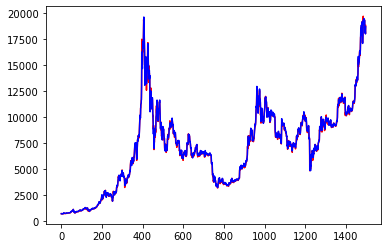

In [48]:
fig, btc_ax = plt.subplots()
btc_ax.plot(btc_y,color="r")
btc_ax.plot(btc_yhat,color="b")

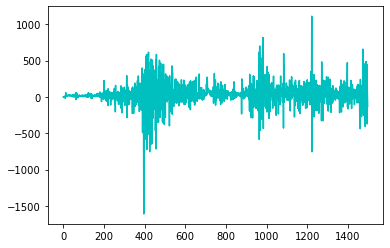

In [49]:
btc_y=btc_y.reshape((btc_y.shape[0],1))
btc_dif_y=btc_yhat-btc_y
fig, btc_ax = plt.subplots()#figsize=(120, 60)
btc_ax.plot(btc_dif_y,color='c')

In [50]:
form(btc_yhat_valid,btc_y_valid)

Mean
[[649.2496951444892, 0.03512027088464233], [796.2186574062496, -0.01128377758658082], [962.4962958728448, -0.01124938218273695], [906.1872099629629, 0.036878569112860644], [0.8045112781954887, 1.026648715529948]]
Count
[186, 20, 58, 135, 399]
acc: %0.8045112781954887
Max
[[3481.7277774999966, 0.19510779364778952], [2825.4350787500007, -0.0013402539978180487], [2910.482920000002, -2.883425503652371e-05], [8719.698486250003, 0.14498277737817103], [True, 1.1951077936477894]]
Min
[[22.5921712499985, 3.7493373567202853e-06], [78.96713875000569, -0.036696131782947], [147.2055862499983, -0.05326694705104745], [2.3441975000023376, 0.000890333314277653], [False, 0.9467330529489526]]


array([1.77149124e+35])

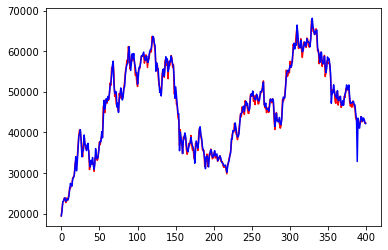

In [51]:
fig, btc_ax = plt.subplots()
btc_ax.plot(btc_y_valid,color="r")
btc_ax.plot(btc_yhat_valid,color="b")

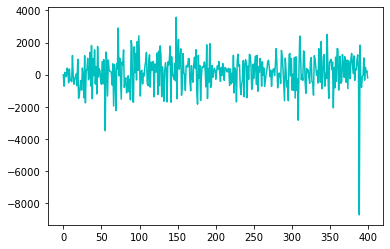

In [52]:
btc_y_valid=btc_y_valid.reshape((btc_y_valid.shape[0],1))
btc_dif_y_valid=btc_yhat_valid-btc_y_valid
fig, btc_ax = plt.subplots()#figsize=(120, 60)
btc_ax.plot(btc_dif_y_valid,color='c')

In [53]:
eth_yhat = eth_model.predict(eth_X)
eth_yhat_valid = eth_model.predict(eth_X_valid)
form(eth_yhat,eth_y)

Mean
[[5.609453418046612, 0.052626678973593334], [5.169099363264351, -0.008704537620123923], [8.406275381070266, -0.01308017096736249], [4.790593988137593, 0.03631312738377475], [0.8510354041416166, 1.0358123079154609]]
Count
[578, 191, 32, 696, 1497]
acc: %0.8510354041416166
Max
[[71.95139737109378, 0.29217740146982335], [42.06558171171878, -1.671071489576322e-05], [54.234011226562416, -0.00011383286987402487], [53.03911251562499, 0.4410633634812707], [True, 1.4410633634812706]]
Min
[[0.0025994001952938106, 6.708844975034583e-05], [0.0819425092885746, -0.0397745485027416], [0.20264565060986328, -0.04465629922498815], [0.013077767968724174, 6.0442905334623365e-05], [False, 0.9553437007750119]]


array([2.5155403e+131])

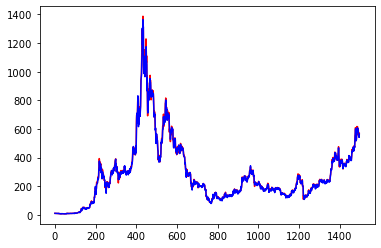

In [54]:
fig, eth_ax = plt.subplots()
eth_ax.plot(eth_y,color="r")
eth_ax.plot(eth_yhat,color="b")

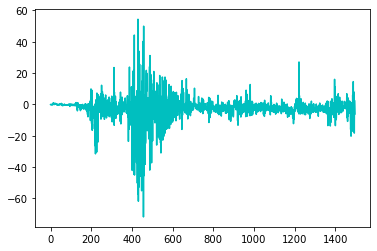

In [55]:
eth_y=eth_y.reshape((eth_y.shape[0],1))
eth_dif_y=eth_yhat-eth_y
fig, eth_ax = plt.subplots()#figsize=(120, 60)
eth_ax.plot(eth_dif_y,color='c')

In [56]:
form(eth_yhat_valid,eth_y_valid)

Mean
[[81.46454706153386, 0.058439129401408836], [89.74083172956155, -0.018239231223744393], [24.90783590234372, -0.010789406768182302], [46.150213071020644, 0.040995717484741276], [0.7568922305764411, 1.0323969611794346]]
Count
[131, 93, 4, 171, 399]
acc: %0.7568922305764411
Max
[[233.95077464062524, 0.2642298752386079], [275.85873715625075, -1.7316388982556728e-05], [57.86852815625002, -0.001975994787683139], [335.56647748437535, 0.2765006568953808], [True, 1.2765006568953807]]
Min
[[0.2212426929687581, 0.0003762865777129519], [12.22356203749996, -0.07621475303018994], [7.602813296874956, -0.03482852223179002], [0.0914510492187901, 0.0019631289181387033], [False, 0.92378524696981]]


array([1.00826138e+36])

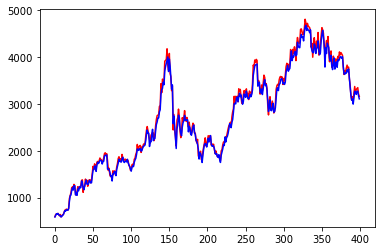

In [57]:
fig, eth_ax = plt.subplots()
eth_ax.plot(eth_y_valid,color="r")
eth_ax.plot(eth_yhat_valid,color="b")

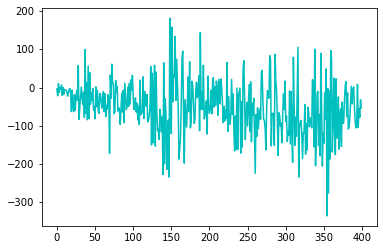

In [58]:
eth_y_valid=eth_y_valid.reshape((eth_y_valid.shape[0],1))
eth_dif_y_valid=eth_yhat_valid-eth_y_valid
fig, eth_ax = plt.subplots()#figsize=(120, 60)
eth_ax.plot(eth_dif_y_valid,color='c')